In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import datetime
import geopandas as gpd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import helper

In [2]:
pd.set_option('display.max_rows', 150)

In [3]:
import matplotlib.style as style
plt.style.use("markerr.mplstyle")

#### prepping for mapping 

In [4]:
# source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2018.html
zips = gpd.read_file('cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp')
zips['GEOID10'] = zips['GEOID10'].astype(int)
target_zips = pd.read_csv('target.csv', index_col = 0)



In [5]:
# lists of relevent zipcodes
houston_zips_list = list(target_zips[target_zips['City']=='Houston']['zip_code'].unique())
paso_zips_list = list(target_zips[target_zips['City']=='El Paso']['zip_code'].unique())
san_zips_list = list(target_zips[target_zips['City']=='San Antonio']['zip_code'].unique())
austin_zips_list = list(target_zips[target_zips['City']=='Austin']['zip_code'].unique())
dallas_zips_list = list(target_zips[target_zips['City']=='Dallas-Fort Worth']['zip_code'].unique())

# limitting the zips to just inside the region around TX 
zips = zips[zips['AFFGEOID10'].str[0:10] == '8600000US7'].reset_index()

# limiting to the inidvidual regions of interest
houston_zips = zips.loc[zips.loc[:,'GEOID10'].isin(houston_zips_list),:]
paso_zips = zips.loc[zips.loc[:,'GEOID10'].isin(paso_zips_list),:]
san_zips = zips.loc[zips.loc[:,'GEOID10'].isin(san_zips_list),:]
austin_zips = zips.loc[zips.loc[:,'GEOID10'].isin(austin_zips_list),:]
dallas_zips = zips.loc[zips.loc[:,'GEOID10'].isin(dallas_zips_list),:]

# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# # looping the graphing to make sure it works
# for metro in different_metros.keys():
#     fig,ax = plt.subplots()
#     zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
#     different_metros[metro].plot(ax=zip_boundry_map, zorder=2, legend=False, column = 'GEOID10', cmap='hsv')

#     zip_boundry_map.axis('off')

#     minx, miny, maxx, maxy = different_metros[metro].total_bounds
#     ax.set_xlim(minx, maxx)
#     ax.set_ylim(miny, maxy)
#     plt.title(metro)
#     plt.show()

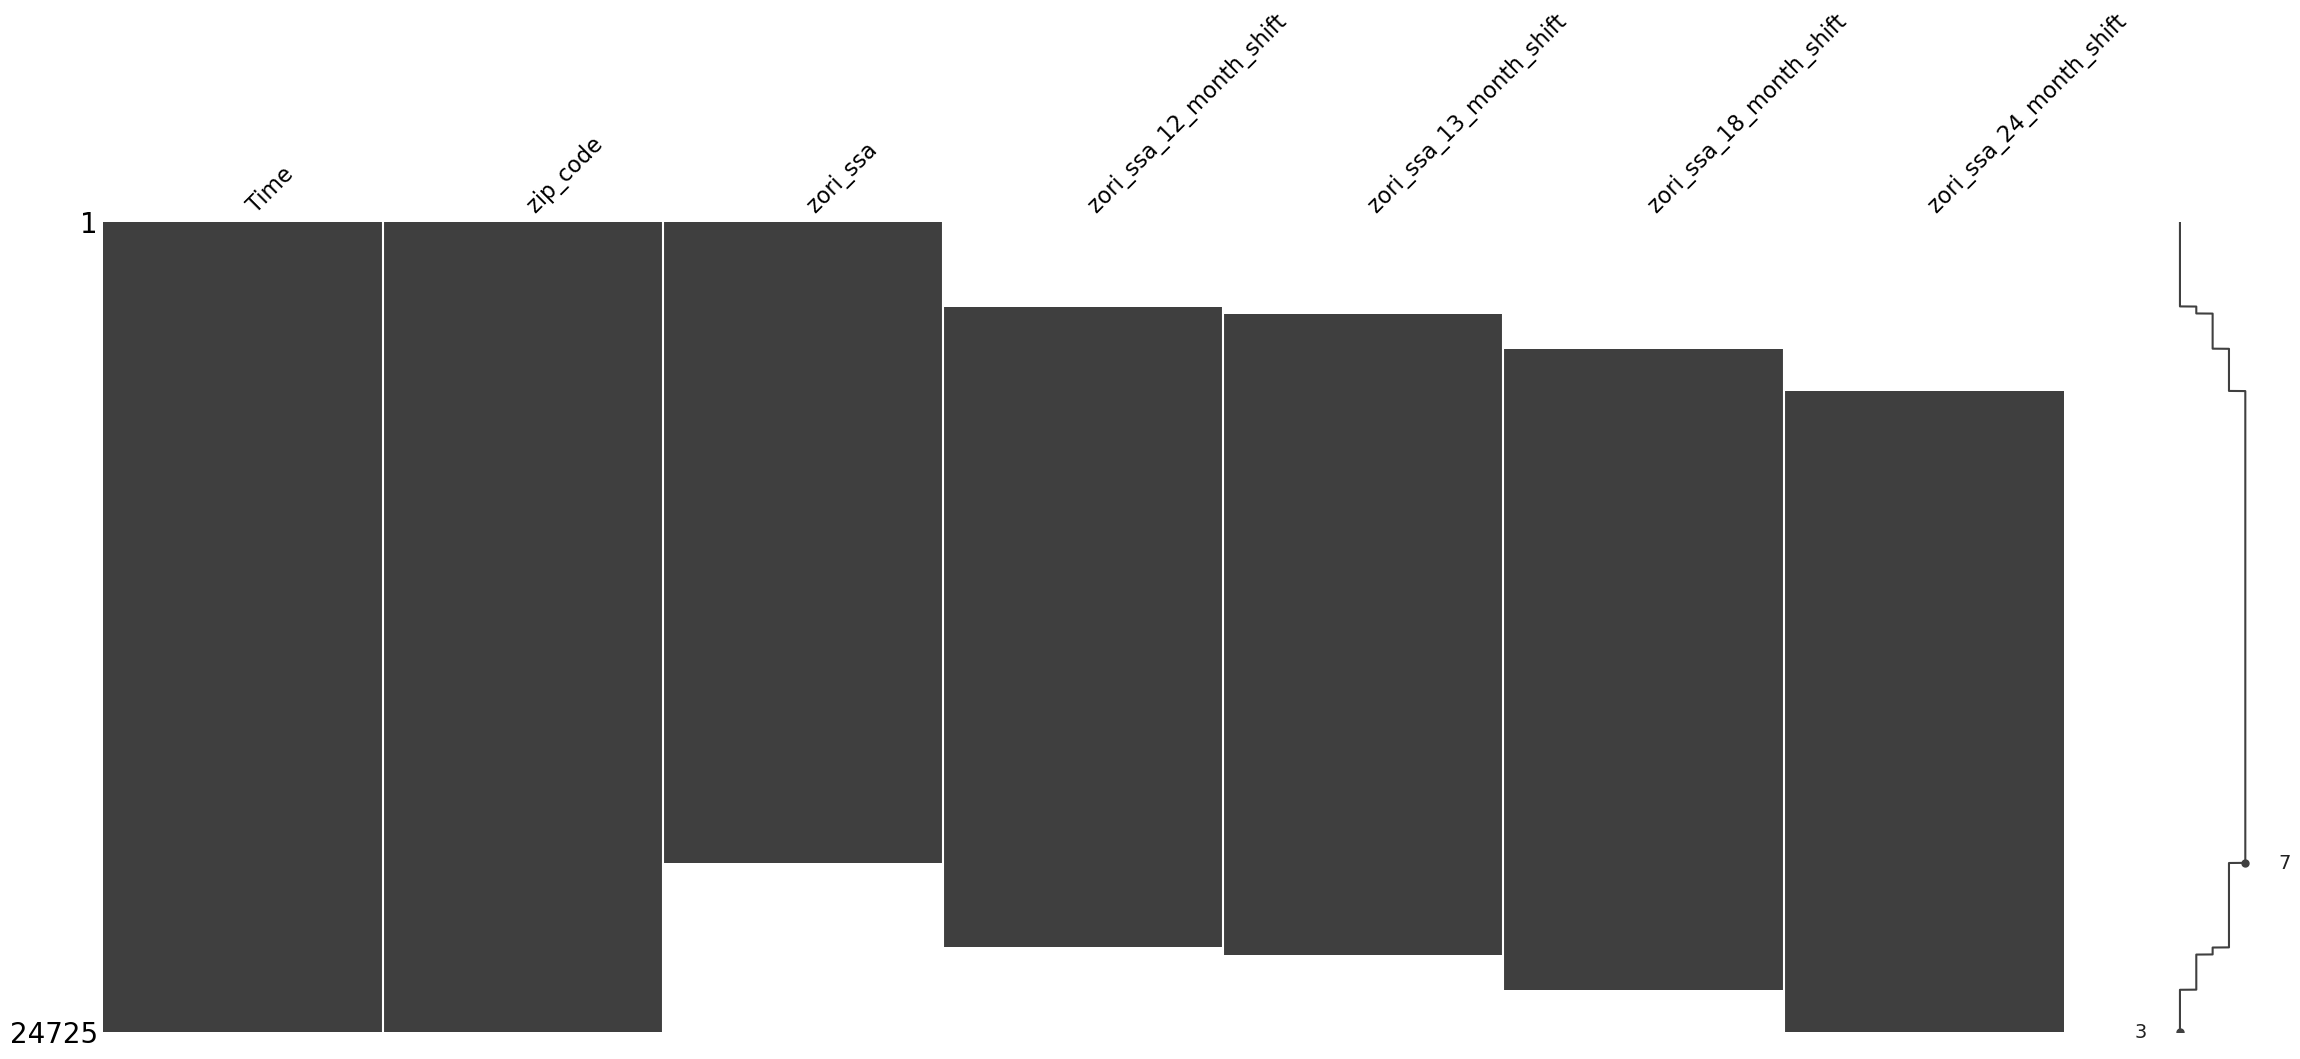

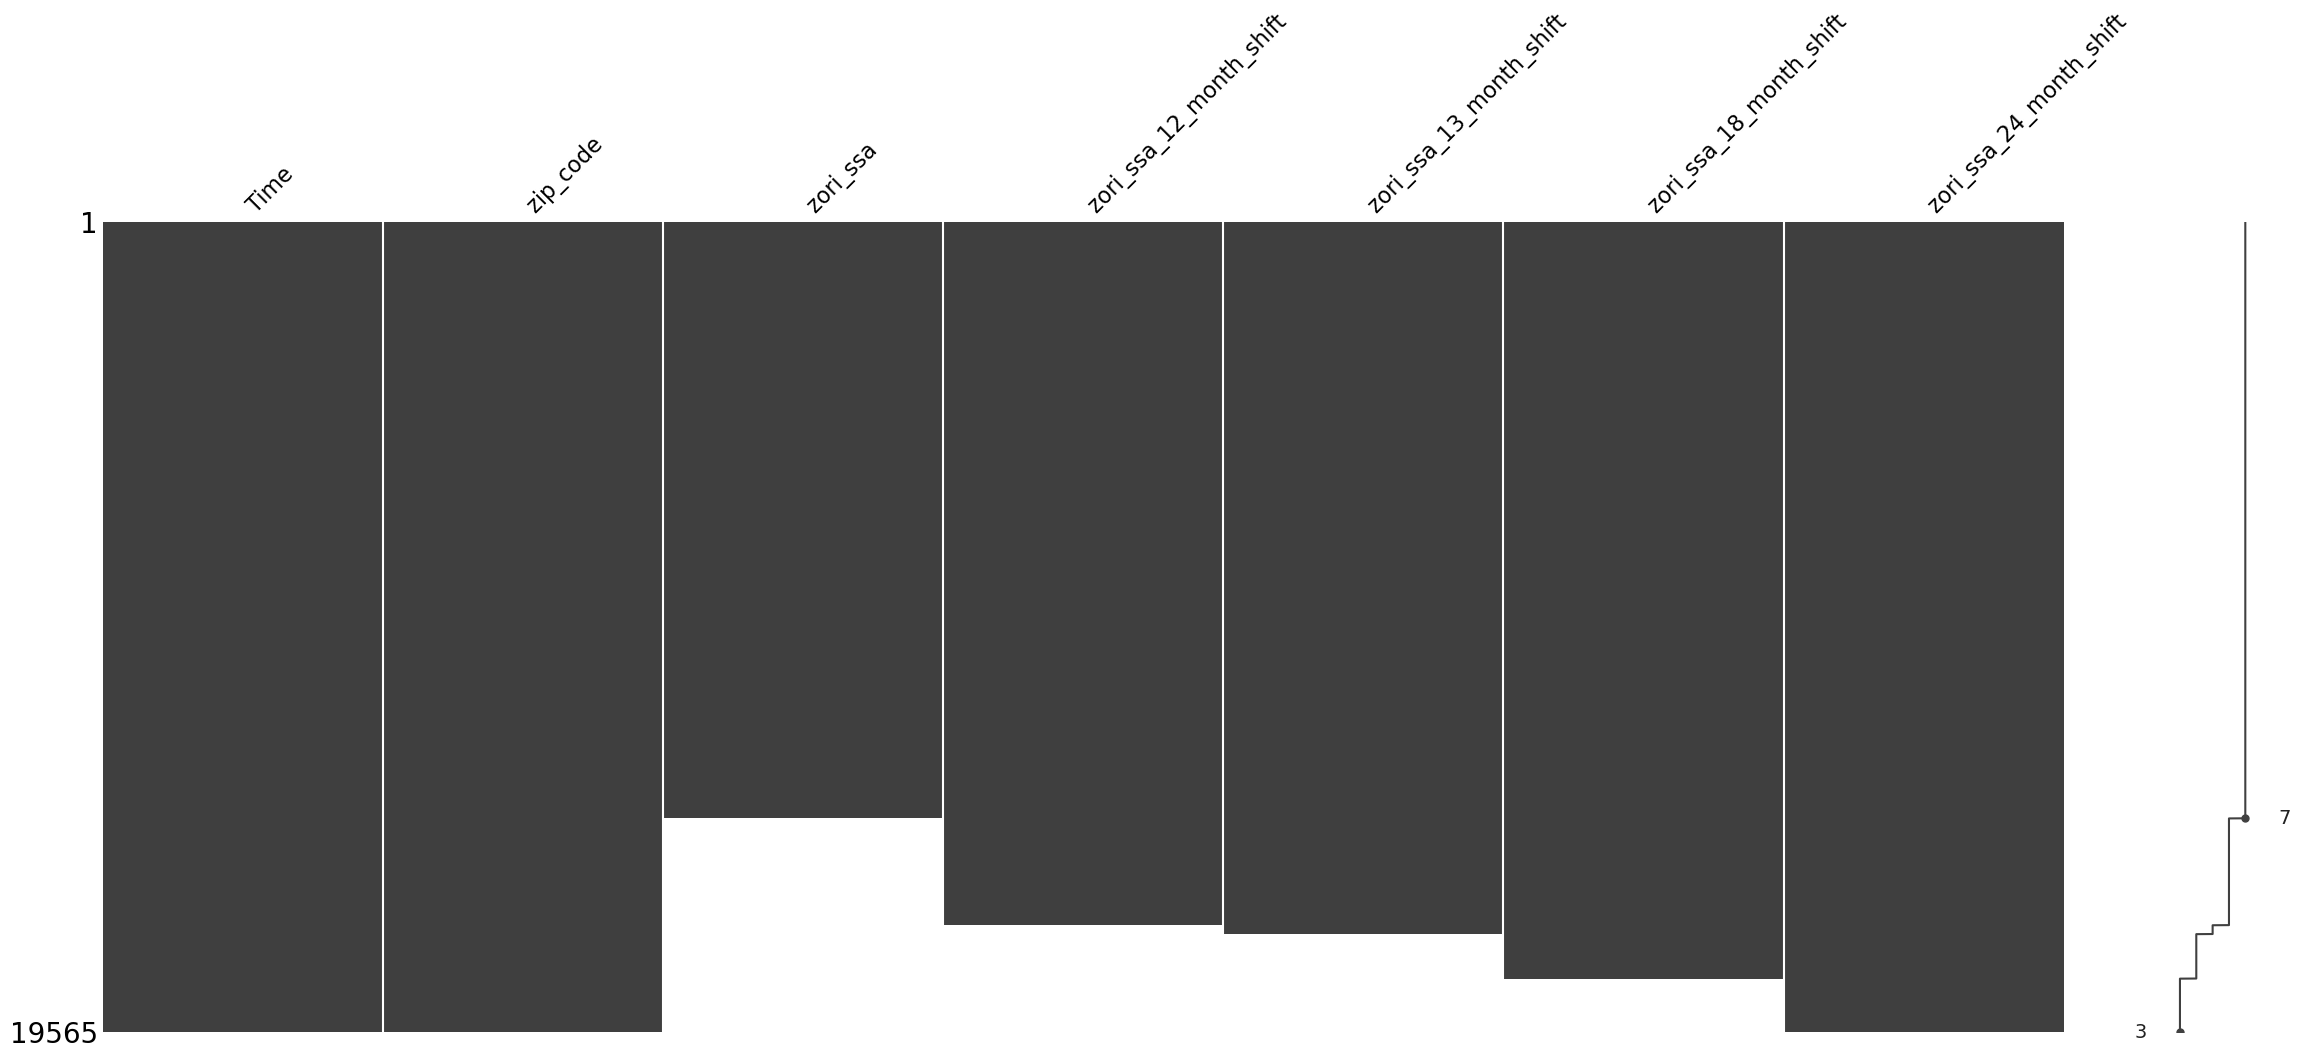

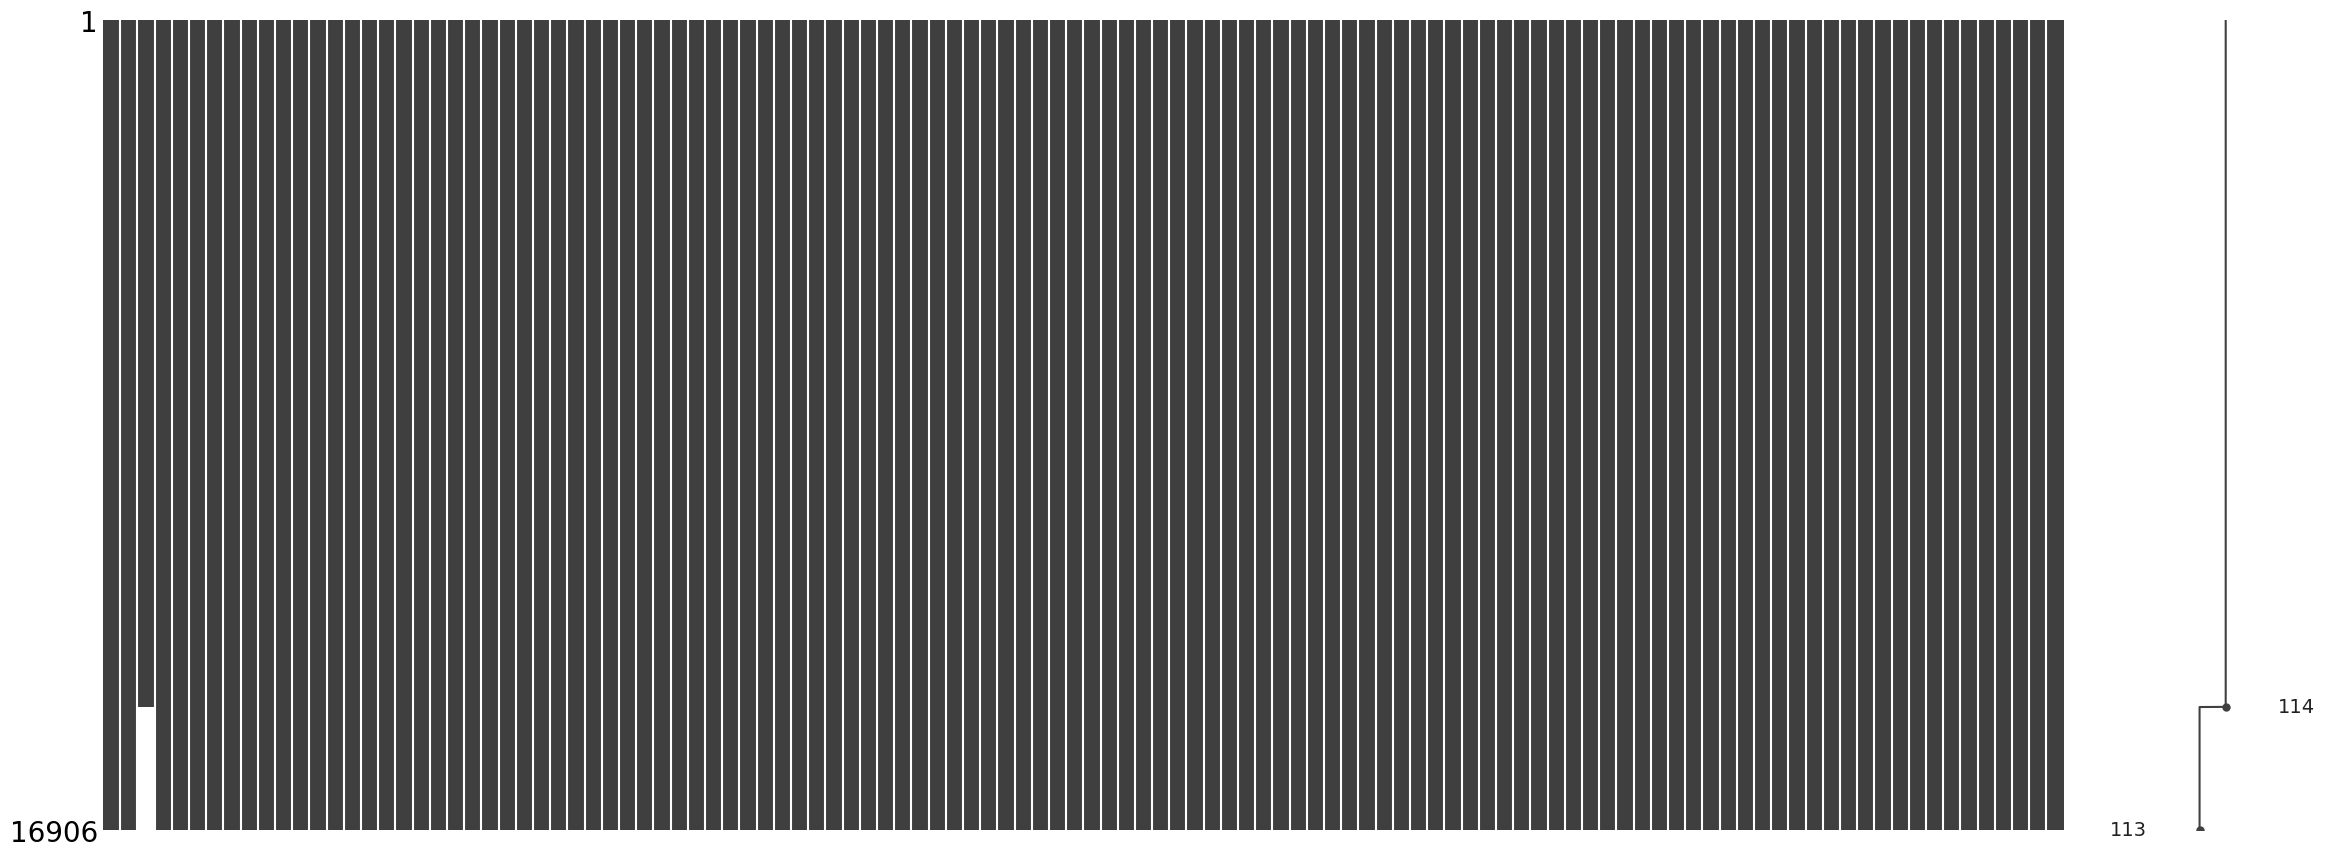

In [6]:
# load data
texas_data = pd.read_csv('merged_texas_data.csv', index_col = 0,
                   parse_dates = ['Time']
                  )

acs_data = pd.read_csv('merged_acs_data.csv', index_col = 0,
                      parse_dates = ['Time'])

zri = pd.read_csv('long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )

# adding shift to zri
zri_shift = helper.time_lag_merge(zri, zri, {
    12:['zori_ssa'],
    13:['zori_ssa'],
    18:['zori_ssa'],
    24:['zori_ssa']
},
                                          return_full = True
                                         )

# there should now be extra values after our target. 
# We are gonna remove the missing values that happen at the start of our inputs tho
zri_shift = zri_shift.sort_values('Time')
msno.matrix(zri_shift)
plt.show()
zri_shift = zri_shift.dropna(subset = ['zori_ssa_24_month_shift'],axis='index',
                             how = 'any').reset_index(drop = True)
msno.matrix(zri_shift)
plt.show()
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_13_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_18_month_shift'])
zri_shift.loc[:,'zori_ssa_12_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_24_month_shift'])
zri_shift['zori_ssa_12_diff_lag_12_per'] = (zri_shift['zori_ssa_12_diff_lag_12']/
                                           zri_shift['zori_ssa_12_month_shift'])

zri_shift = zri_shift[['Time','zip_code','zori_ssa', 
                       'zori_ssa_12_month_shift',
                       'zori_ssa_1_diff_lag_12', 
                       'zori_ssa_6_diff_lag_12',
                       'zori_ssa_12_diff_lag_12_per'
                      ]]


# merge non acs data 
extra_shift = ['Gross Value Natural Gas Production', 'sap_case_shiller_index']
merged_df = helper.time_lag_merge(zri_shift, 
                                                    texas_data, {
    12:list(texas_data.drop(columns = ['Time','zip_code']+extra_shift
                            ).columns),
    13:extra_shift
},
                                          return_full = True
                                         )
# merge acs data
acs_1_cols = [
    'black_pop',
    'white_pop',
    'hispanic_pop',
    'high_school_diploma',
    'female_female_households',
    'armed_forces',
    'children',
    'black_pop_annual_pct_change',
    'white_pop_annual_pct_change',
    'hispanic_pop_annual_pct_change',
    'high_school_diploma_annual_pct_change',
    'children_annual_pct_change',
    ]
merged_df = helper.time_lag_merge(merged_df, 
                                                    acs_data, {
    36:list(acs_data.drop(columns = ['Time','zip_code'] + acs_1_cols).columns),
    48:acs_1_cols                                              
},
                                          return_full = True
                                         )
# # visualize missing values. it should be that acs 2 does not have a single zipcode
# # then removing that line and checking to see that there are no more missing values.
merged_df = merged_df.loc[merged_df['Time']>datetime.datetime(2016,6,2),:
                          ].reset_index(drop=True)
merged_df = merged_df.loc[merged_df['Time']<datetime.datetime(2022,7,2),:
                          ].reset_index(drop=True)
merged_df = merged_df.sort_values('Time')
merged_df = merged_df.dropna(subset = ['single_women_36_month_shift'],axis='index',
                             how = 'any').reset_index(drop = True)

# this now should have no missing values except for the last year when 
# we are doing a forecast
msno.matrix(merged_df)
plt.show()

In [7]:
# creating list of variables to put into the model. initialy is all non index and target
X_vals = [
    'zori_ssa_12_month_shift',
    'zori_ssa_1_diff_lag_12',
    'zori_ssa_6_diff_lag_12',
    'total_sales_tax_12_month_shift',
    'housing_units_over_50_units_36_month_shift',
    'housing_units_built_1960_to_1969_36_month_shift',
    'black_pop_48_month_shift',
    'zori_ssa_12_diff_lag_12_per',
    'children_annual_pct_change_48_month_shift',
    'female_40_to_44_annual_pct_change_36_month_shift',
    'housing_units_10_to_19_units_annual_pct_change_36_month_shift',
    'sales_tax_rate_annual_pct_change_12_month_shift',
    'female_female_households_48_month_shift',
    'women_with_associate_degree_annual_pct_change_36_month_shift',
    'average_household_size_owners_annual_pct_change_36_month_shift',
    'units_paying_cash_rent_annual_pct_change_36_month_shift',
    'quintile_1_upper_limit_annual_pct_change_36_month_shift',
    'Gross Value Natural Gas Production_13_month_shift',
    'women_with_doctoral_degree_annual_pct_change_36_month_shift',
    'total_sales_tax_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_36_month_shift',
    'housing_units_built_1980_to_1989_annual_pct_change_36_month_shift',
    'female_35_to_39_annual_pct_change_36_month_shift',
    'bicycle_population_36_month_shift',
    'housing_units_20_to_49_units_annual_pct_change_36_month_shift',
    'taxpayer_count_12_month_shift',
    'housing_units_5_to_9_units_36_month_shift',
    'high_school_diploma_annual_pct_change_48_month_shift',
    'driving_alone_population_annual_pct_change_36_month_shift',
    'taxpayer_is_ratio_12_month_shift',
    'motorcycle_population_36_month_shift',
    'housing_units_built_1960_to_1969_annual_pct_change_36_month_shift',
    'housing_units_single_family_attached_annual_pct_change_36_month_shift',
    'white_pop_annual_pct_change_48_month_shift',
    'taxpayer_cl_ratio_annual_pct_change_12_month_shift',
    'taxpayer_is_ratio_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_annual_pct_change_36_month_shift',
    'housing_units_5_to_9_units_annual_pct_change_36_month_shift',
    'median_household_income_annual_pct_change_36_month_shift',
    'black_pop_annual_pct_change_48_month_shift',
    'Gross Value Natural Gas Production_annual_pct_change_12_month_shift',
    'housing_units_single_family_attached_owned_36_month_shift',
    'single_women_annual_pct_change_36_month_shift',
    'housing_units_built_1930_to_1939_36_month_shift',
    'housing_units_built_1930_to_1939_annual_pct_change_36_month_shift',
    'female_25_to_29_annual_pct_change_36_month_shift',
    'female_30_to_34_annual_pct_change_36_month_shift',
    'housing_units_over_50_units_annual_pct_change_36_month_shift',
]
# then remove variables that don't work for that given model.
bad_X_vals = [
             ]
X_vals = [X_val for X_val in X_vals if X_val not in bad_X_vals]
y_val = 'zori_ssa'

# split train and test based on a year in advance.
train = merged_df.loc[merged_df['Time']<datetime.datetime(2020,7,2),:].reset_index(drop=True)
post_train = merged_df.loc[merged_df['Time']>datetime.datetime(2020,7,2),:].reset_index(drop=True)
test = post_train.loc[post_train['Time']<datetime.datetime(2021,7,2),:].reset_index(drop=True)
forecast = post_train.loc[post_train['Time']>datetime.datetime(2021,7,2),:].reset_index(drop=True)

# set up x and y values with a scaler
# train first
scaler = StandardScaler(with_mean=False)
X = train[X_vals]
X = scaler.fit_transform(X)
y = train[y_val]
# test second
X_test = test[X_vals]
X_test = scaler.transform(X_test)
y_test = test[y_val]
# forecasted values
X_forecast = forecast[X_vals]
X_forecast = scaler.transform(X_forecast)

In [8]:
scaler = StandardScaler(with_mean=False)
net = ElasticNet(max_iter = 50000)

l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1]
alpha = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6]
tuned_parameters = [{'alpha': alpha, 'l1_ratio': l1_ratio}]
print(f'Performing Grid Search with \nalphas of: {alpha}\nl1_ratios of: {l1_ratio}')
clf = GridSearchCV(net, tuned_parameters, 
                   cv=5,n_jobs = -1, verbose=3,
                   scoring = 'neg_root_mean_squared_error')

clf.fit(X, y)

y_predicted = clf.predict(X_test)
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_predicted

rms = mean_squared_error(y_test, y_predicted, squared=False)
test.loc[:,'pred'] = y_predicted
print(f"Best alpha {clf.best_params_['alpha']}")
print(f"Best l1_ratio {clf.best_params_['l1_ratio']}")

Performing Grid Search with 
alphas of: [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6]
l1_ratios of: [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1]
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best alpha 0.1
Best l1_ratio 1


In [9]:
clf.best_params_

{'alpha': 0.1, 'l1_ratio': 1}

In [13]:
coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
unselected_coef_df = coef_df[coef_df['coefs']==0]
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
coef_df.features.to_list()

['zori_ssa_12_month_shift',
 'zori_ssa_1_diff_lag_12',
 'zori_ssa_6_diff_lag_12',
 'total_sales_tax_12_month_shift',
 'zori_ssa_12_diff_lag_12_per',
 'housing_units_over_50_units_36_month_shift',
 'housing_units_built_1960_to_1969_36_month_shift',
 'children_annual_pct_change_48_month_shift',
 'black_pop_48_month_shift',
 'housing_units_single_family_attached_owned_36_month_shift',
 'Gross Value Natural Gas Production_13_month_shift',
 'female_40_to_44_annual_pct_change_36_month_shift',
 'units_paying_cash_rent_annual_pct_change_36_month_shift',
 'sales_tax_rate_annual_pct_change_12_month_shift',
 'housing_units_10_to_19_units_annual_pct_change_36_month_shift',
 'female_35_to_39_annual_pct_change_36_month_shift',
 'quintile_1_upper_limit_annual_pct_change_36_month_shift',
 'average_household_size_owners_annual_pct_change_36_month_shift',
 'women_with_associate_degree_annual_pct_change_36_month_shift',
 'women_with_doctoral_degree_annual_pct_change_36_month_shift',
 'total_sales_tax_ann

In [11]:
coef_df.to_csv('elastic_net_pick_blind.csv')

/Users/haydenlw4/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


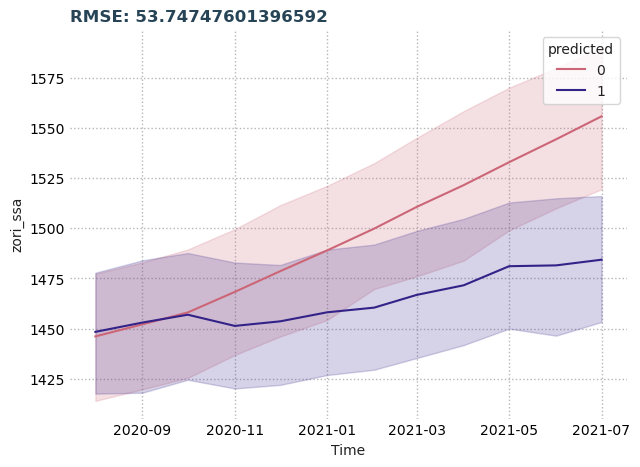

In [12]:
graph_df1 = test[['Time',y_val]]
graph_df1.loc[:,'predicted'] = 0 
graph_df2 = test[['Time','pred']].rename(columns={'pred':y_val})
graph_df2.loc[:,'predicted'] = 1
graph_df = pd.concat([graph_df1,graph_df2]).reset_index(drop=True)

g = sns.lineplot(data = graph_df, x = 'Time',y = y_val, hue = 'predicted')
plt.title(f'RMSE: {rms}')
plt.show()

In [46]:
unselected_coef_df.features.to_list()

['zori_ssa_12_diff_lag_12_per',
 'sales_tax_rate_12_month_shift',
 'tx_is_better_12_month_shift',
 'tx_is_worse_12_month_shift',
 'Single Family Building Permits TX_12_month_shift',
 'taxpayer_is_ratio_12_month_shift',
 'taxpayer_foreign_ratio_12_month_shift',
 'mintempC_annual_pct_change_12_month_shift',
 'tx_is_abt_same_annual_pct_change_12_month_shift',
 'tx_is_worse_annual_pct_change_12_month_shift',
 'Single Family Building Permits TX_annual_pct_change_12_month_shift',
 'taxpayer_count_annual_pct_change_12_month_shift',
 'taxpayer_cl_ratio_annual_pct_change_12_month_shift',
 'taxpayer_is_ratio_annual_pct_change_12_month_shift',
 'sap_case_shiller_index_13_month_shift',
 'driving_alone_population_36_month_shift',
 'female_45_to_49_36_month_shift',
 'housing_units_built_1950_to_1959_36_month_shift',
 'bicycle_population_36_month_shift',
 'quintile_4_upper_limit_36_month_shift',
 'quintile_3_upper_limit_36_month_shift',
 'housing_units_10_to_19_units_36_month_shift',
 'female_50_to_5

In [ ]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
g = sns.boxplot(data = graph_df, x = 'Time',y = 'pred_difference', 
                )
plt.title(f'RMSE: {rms}')
plt.show()

In [ ]:
test['pred_12_month_growth'] = test['pred'] - test['zori_ssa_12_month_shift']
test['actual_12_month_growth'] = test['zori_ssa'] - test['zori_ssa_12_month_shift']

test['pred_12_month_growth_per'] = test['pred_12_month_growth']/test['zori_ssa_12_month_shift']
test['actual_12_month_growth_per'] = test['actual_12_month_growth']/test['zori_ssa_12_month_shift']
test['pred_difference_per'] = test['pred_difference']/test['zori_ssa_12_month_shift']
# test['month'] = test['Time'].dt.month

g = sns.scatterplot(data = test, x = 'pred_12_month_growth_per', 
                y = 'actual_12_month_growth_per', hue='Time')

sns.move_legend(g,"upper left", bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
g = sns.JointGrid(data=test, x = 'pred_12_month_growth_per', 
                y = 'actual_12_month_growth_per', hue='Time',
                 )


g.plot_joint(sns.scatterplot,)
g.plot_marginals(sns.kdeplot,legend=False)

g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')

plt.show()

In [ ]:

for month in test.Time.unique():
    g = sns.JointGrid(data=test[test['Time']==month], x = 'pred_12_month_growth_per', 
                    y = 'actual_12_month_growth_per', hue='Time',
                     )


    g.plot_joint(sns.scatterplot,)
    g.plot_marginals(sns.kdeplot,legend=False)

    g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')
    g.fig.suptitle("")
    plt.show()

In [ ]:
map_ = test
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():


    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["actual_12_month_growth_per"], 
    #               scheme='equal_interval', k=4,
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' Actual actual_12_month_growth_per\nBy Zip Code')
    plt.show()

In [ ]:
map_ = test
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():


    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["pred_difference_per"], 
    #               scheme='equal_interval', k=4,
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro+' Predicted pred_difference_per\nBy Zip Code')
    plt.show()

In [ ]:
five_per_zips = list(test[test['pred_12_month_growth_per']>.05].zip_code.unique())
naive_five_per_zips = list(test[test['zori_ssa_12_diff_lag_12_per']>.05].zip_code.unique())


In [ ]:
test.loc[:,'invest_rec_5_per'] = 0
test.loc[test['zip_code'].isin(five_per_zips),'invest_rec_5_per'] = 3
test.loc[test['zip_code'].isin(naive_five_per_zips),'invest_rec_5_per'] = 1
test.loc[(test['zip_code'].isin(naive_five_per_zips) &
          test['zip_code'].isin(five_per_zips))
          ,'invest_rec_5_per'] = 2


In [ ]:
test.loc[test['invest_rec_5_per']==3,'zip_code'].unique()

In [ ]:
color = ['#882255','#cc6677','#88ccee','#332288']
zips_code = [0,1,2,3]
color_mapping = dict(zip(zips_code,color))

map_ = test
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["invest_rec_5_per"], 
                  color=graph_df["invest_rec_5_per"].map(color_mapping),
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' invest_rec_5_per\nBy Zip Code')
    plt.show()

In [ ]:
g = sns.JointGrid(data=test, x = 'pred_12_month_growth_per', 
                y = 'actual_12_month_growth_per', hue='invest_rec_5_per',
                 )


g.plot_joint(sns.scatterplot,)
g.plot_marginals(sns.kdeplot,legend=False)

g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')

plt.show()

In [ ]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
g = sns.boxplot(data = graph_df, x = 'invest_rec_5_per',y = 'actual_12_month_growth_per', 
                )
plt.title(f'RMSE: {rms}')
plt.show()

In [ ]:
# # zri_shift 6-12 months
# zri_shift, zri_shift_X_vals = helper.time_lag_merge(zri, zri, {
#     6:['zori_ssa'],
#     7:['zori_ssa'],
#     12:['zori_ssa'],
#     18:['zori_ssa']
# },
#                                           return_cols = True
#                                          )
# zri_shift = zri_shift.dropna(axis='index',how = 'any').reset_index(drop = True)
# # Adding the shift values
# zri_shift.loc[:,'zori_ssa_1_diff__lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
#                                              zri_shift.loc[:,'zori_ssa_7_month_shift'])
# zri_shift.loc[:,'zori_ssa_6_diff_lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
#                                              zri_shift.loc[:,'zori_ssa_12_month_shift'])
# zri_shift.loc[:,'zori_ssa_12_diff_lag_6'] = (zri_shift.loc[:,'zori_ssa_6_month_shift'] -
#                                              zri_shift.loc[:,'zori_ssa_18_month_shift'])
# zri_shift = zri_shift[['Time','zip_code','zori_ssa','zori_ssa_6_month_shift',
#                        'zori_ssa_12_month_shift',
#                        'zori_ssa_1_diff__lag_6','zori_ssa_6_diff_lag_6',
#                        'zori_ssa_12_diff_lag_6']]


In [ ]:
# X_vals = ['zori_ssa_6_month_shift',
#                        'zori_ssa_12_month_shift',
#                        'zori_ssa_1_diff__lag_6','zori_ssa_6_diff_lag_6',
#                        'zori_ssa_12_diff_lag_6']
# y_val = 'zori_ssa'

# # for metro in metros:
# train = zri_shift.loc[zri_shift['Time']<datetime.datetime(2021,1,2),:].reset_index(drop=True)
# test = zri_shift.loc[zri_shift['Time']>datetime.datetime(2021,1,2),:].reset_index(drop=True)
# cat_feats_=[]

# scaler = StandardScaler(with_mean=False)
# lasso = Lasso(max_iter = 50000, random_state = 33)

# X = train[X_vals]
# transformer = ColumnTransformer([("Cat", 
#                                   OneHotEncoder(handle_unknown = 'ignore'), 
#                                   cat_feats_)], remainder='passthrough')
# X = transformer.fit_transform(X)
# X = scaler.fit_transform(X)
# y = train[y_val]

# # Grid Search set up.

# alphas = [0.3, 0.6, 1]
# tuned_parameters = [{'alpha': alphas}]
# print(f'Performing Grid Search with alphas of: {alphas}')
# clf = GridSearchCV(lasso, tuned_parameters, 
#                     cv=3,n_jobs = -1,
#                   scoring = 'neg_root_mean_squared_error')
# # best_alpha = clf.best_params_['alpha']
# clf.fit(X, y)

# X_test = test[X_vals]
# X_test = transformer.transform(X_test)
# X_test = scaler.transform(X_test)
# y_test = test[y_val]
# y_predicted = clf.predict(X_test)
# test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_predicted

# rms = mean_squared_error(y_test, y_predicted, squared=False)
# test.loc[:,'pred'] = y_predicted

In [ ]:
# test['pred_6_month_growth'] = test['pred'] - test['zori_ssa_6_month_shift']
# test['actual_6_month_growth'] = test['zori_ssa'] - test['zori_ssa_6_month_shift']

In [ ]:
# test['pred_6_month_growth_per'] = test['pred_6_month_growth']/test['zori_ssa_6_month_shift']
# test['actual_6_month_growth_per'] = test['actual_6_month_growth']/test['zori_ssa_6_month_shift']
# test['pred_difference_per'] = test['pred_difference']/test['zori_ssa_6_month_shift']
# test['month'] = test['Time'].dt.month


In [ ]:
# g = sns.scatterplot(data = test, x = 'pred_6_month_growth_per', 
#                 y = 'actual_6_month_growth_per', hue='Time')

# sns.move_legend(g,"upper left", bbox_to_anchor=(1, 1))
# plt.show()

In [ ]:
# g = sns.JointGrid(data=test, x = 'pred_6_month_growth_per', 
#                 y = 'actual_6_month_growth_per', hue='Time',
#                  )


# g.plot_joint(sns.scatterplot,)
# g.plot_marginals(sns.kdeplot,legend=False)

# g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
# x0, x1 = g.ax_joint.get_xlim()
# y0, y1 = g.ax_joint.get_ylim()
# lims = [max(x0, y0), min(x1, y1)]
# g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')

# plt.show()

In [ ]:
# g = sns.scatterplot(data = test, x = 'pred_6_month_growth', y = 'actual_6_month_growth', 
#                hue = 'Time')

# sns.move_legend(g,"upper left", bbox_to_anchor=(1, 1))

# plt.show()

In [ ]:
# sns.scatterplot(data = test, x = 'pred_6_month_growth', y = 'actual_6_month_growth', 
#                hue = 'pred_difference')
# plt.show()

In [ ]:
# sns.scatterplot(data = test[test['month']==7], x = 'pred_6_month_growth', y = 'actual_6_month_growth', 
#                hue = 'pred_difference')
# plt.show()

In [ ]:
# graph_df1 = test[['Time',y_val]]
# graph_df1.loc[:,'predicted'] = 0 
# graph_df2 = test[['Time','pred']].rename(columns={'pred':y_val})
# graph_df2.loc[:,'predicted'] = 1
# graph_df = pd.concat([graph_df1,graph_df2]).reset_index(drop=True)

# g = sns.lineplot(data = graph_df, x = 'Time',y = y_val, hue = 'predicted')
# plt.title(f'RMSE: {rms}')
# plt.show()

In [ ]:
# sns.lineplot(data = zri,  x = 'Time',y = y_val)
# plt.show()

In [ ]:
# graph_df = test
# graph_df['month'] = graph_df['Time'].dt.month
# g = sns.boxplot(data = graph_df, x = 'month',y = 'pred_difference', 
#                 )
# plt.title(f'RMSE: {rms}')
# plt.show()

In [ ]:
# coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
# coef_df = coef_df[coef_df['coefs']!=0]
# coef_df['coefs_abs'] = abs(coef_df['coefs'])
# coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)
# coef_df

In [ ]:
# map_ = test[test['Time'].dt.month==4]
# # dictionary of each cities zipcodes
# different_metros = {'Houston' : houston_zips, 
#                     'El Paso' : paso_zips, 
#                     'San Antonio' : san_zips, 
#                     'Austin' : austin_zips, 
#                     'Dallas-Fort Worth' : dallas_zips}

# # looping the graphing to make sure it works
# for metro in different_metros.keys():


#     graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
#     fig,ax = plt.subplots()
#     zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
#     graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["pred_difference"], 
#     #               scheme='equal_interval', k=4,
#                   legend=True,
#                     )

#     zip_boundry_map.axis('off')

#     minx, miny, maxx, maxy = graph_df.total_bounds
#     ax.set_xlim(minx, maxx)
#     ax.set_ylim(miny, maxy)
#     plt.title(metro+' Predicted Difference\nBy Zip Code')
#     plt.show()

In [ ]:
# map_ = test[test['Time'].dt.month==4]
# # dictionary of each cities zipcodes
# different_metros = {'Houston' : houston_zips, 
#                     'El Paso' : paso_zips, 
#                     'San Antonio' : san_zips, 
#                     'Austin' : austin_zips, 
#                     'Dallas-Fort Worth' : dallas_zips}

# # looping the graphing to make sure it works
# for metro in different_metros.keys():


#     graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
#     fig,ax = plt.subplots()
#     zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
#     graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["zori_ssa"], 
#     #               scheme='equal_interval', k=4,
#                   legend=True,
#                     )

#     zip_boundry_map.axis('off')

#     minx, miny, maxx, maxy = graph_df.total_bounds
#     ax.set_xlim(minx, maxx)
#     ax.set_ylim(miny, maxy)
#     plt.title(metro +' Actual ZRI\nBy Zip Code')
#     plt.show()